In [1]:
!wget https://jbdel.github.io/teaching/nn/ressources/rl/lib/envs/cliff_walking.py
!wget https://jbdel.github.io/teaching/nn/ressources/rl/lib/plotting.py

--2019-10-18 07:36:03--  https://jbdel.github.io/teaching/nn/ressources/rl/lib/envs/cliff_walking.py
Resolving jbdel.github.io (jbdel.github.io)... 185.199.110.153, 185.199.108.153, 185.199.111.153, ...
Connecting to jbdel.github.io (jbdel.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2887 (2.8K) [application/octet-stream]
Saving to: ‘cliff_walking.py’

cliff_walking.py    100%[===================>]   2.82K  --.-KB/s    in 0s      

2019-10-18 07:36:03 (49.8 MB/s) - ‘cliff_walking.py’ saved [2887/2887]

--2019-10-18 07:36:05--  https://jbdel.github.io/teaching/nn/ressources/rl/lib/plotting.py
Resolving jbdel.github.io (jbdel.github.io)... 185.199.110.153, 185.199.108.153, 185.199.111.153, ...
Connecting to jbdel.github.io (jbdel.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3468 (3.4K) [application/octet-stream]
Saving to: ‘plotting.py’

plotting.py         100%[===============

In [0]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys

from collections import defaultdict
from cliff_walking import CliffWalkingEnv
import plotting

matplotlib.style.use('ggplot')

In [3]:
env = CliffWalkingEnv()
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [4]:
env = CliffWalkingEnv()

print(env.reset())
env.render()

print(env.step(0))
env.render()

print(env.step(1))
env.render()

print(env.step(1))
env.render()

print(env.step(2))
env.render()

36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

(24, -1.0, False, {'prob': 1.0})
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

(25, -1.0, False, {'prob': 1.0})
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

(26, -1.0, False, {'prob': 1.0})
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

(38, -100.0, True, {'prob': 1.0})
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  x  C  C  C  C  C  C  C  C  T



In [0]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action. Float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [0]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # One step in the environment
        # total_reward = 0.0
        for t in itertools.count():
            
            # Take a step
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            best_next_action = np.argmax(Q[next_state])    
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
                
            if done:
                break
                
            state = next_state
    
    return Q, stats

In [7]:
Q, stats = q_learning(env, 500)

policy = [np.argmax(Q[s]) for s in range(env.nS)]
print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(policy, env.shape))
print("")


Episode 500/500.Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[1 2 1 1 1 0 1 2 1 1 1 2]
 [1 1 2 2 1 1 1 2 1 1 1 2]
 [1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0]]



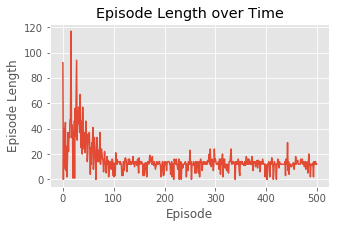

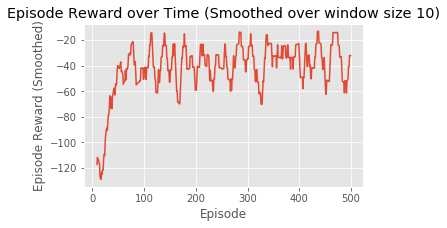

(<Figure size 360x216 with 1 Axes>, <Figure size 360x216 with 1 Axes>)

In [8]:
plotting.plot_episode_stats(stats)

In [22]:
env = CliffWalkingEnv(wind=True)
env.reset()

env.step(0)
env.step(1)
env.render()
#aller en haut
print("UP",env.P[env.s][0])
#aller a droite
print("RIGHT",env.P[env.s][1])


o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

UP [(1.0, 13, -1.0, False)]
RIGHT [(0.8, 26, -1.0, False), (0.2, 37, -100.0, True)]


In [23]:
Q, stats = q_learning(env, 2000)

policy = [np.argmax(Q[s]) for s in range(env.nS)]
print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(policy, env.shape))
print("")

Episode 2000/2000.Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[1 1 1 1 1 1 1 1 0 1 1 2]
 [0 1 0 1 1 0 0 0 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 2]
 [0 0 0 0 0 0 0 0 0 0 0 0]]

